In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras.models import Model

In [2]:
tf.keras.backend.clear_session()

In [3]:
root = '/kaggle/input/140k-real-and-fake-faces'

train_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'
val_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid'
test_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'

print(train_dir)
print(val_dir)
print(test_dir)

/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test


In [4]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Val_dir Subfolders: " ,os.listdir(val_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Val_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


In [5]:
#Xây dựng dataframe
images_df = {
    "folder": [],
    "image_path": [],
    "label": []
}
root_dir = [train_dir, val_dir, test_dir]
folders_name = ["train", "valid", "test"]
for folder, folder_name in zip(root_dir, folders_name):
    for label in os.listdir(folder): #fake, real
        for img in glob.glob(os.path.join(folder, label) + "/*.jpg"):
            images_df["folder"].append(folder_name)
            images_df["image_path"].append(img)
            images_df["label"].append(label)
images_df = pd.DataFrame(images_df)

In [6]:
images_df.head()

,folder,image_path,label
0,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
1,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
2,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
3,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
4,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake


In [7]:
real_grouped_df = images_df[images_df["label"] == "real"].groupby("folder") #Gom nhóm img_real theo folder
fake_grouped_df = images_df[images_df["label"] == "fake"].groupby("folder") #Gom nhóm img_fake theo folder

In [8]:
real_grouped_df.size() #Thống kê số lượng img_real theo folder

folder
test     10000
train    50000
valid    10000
dtype: int64

In [9]:
fake_grouped_df.size() #Thống kê số lượng img_fake theo folder

folder
test     10000
train    50000
valid    10000
dtype: int64

In [11]:
image_train_gen = ImageDataGenerator(rescale = 1. / 255., horizontal_flip = True)
image_gen = ImageDataGenerator(rescale = 1. / 255.)

In [12]:
tg_size = (224, 224)
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size = tg_size,
    batch_size = 64,
    class_mode = "binary",
)
valid_ds = image_gen.flow_from_directory(
    val_dir,
    target_size = tg_size,
    batch_size = 64,
    class_mode = "binary",
)
test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size = tg_size,
    batch_size = 64,
    class_mode = "binary",
    shuffle = False
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [13]:
def plot_images(img, label):
    plt.figure(figsize = [12,12])
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if label[i] == 0:
            plt.title("Fake")
        else :
            plt.title("Real")

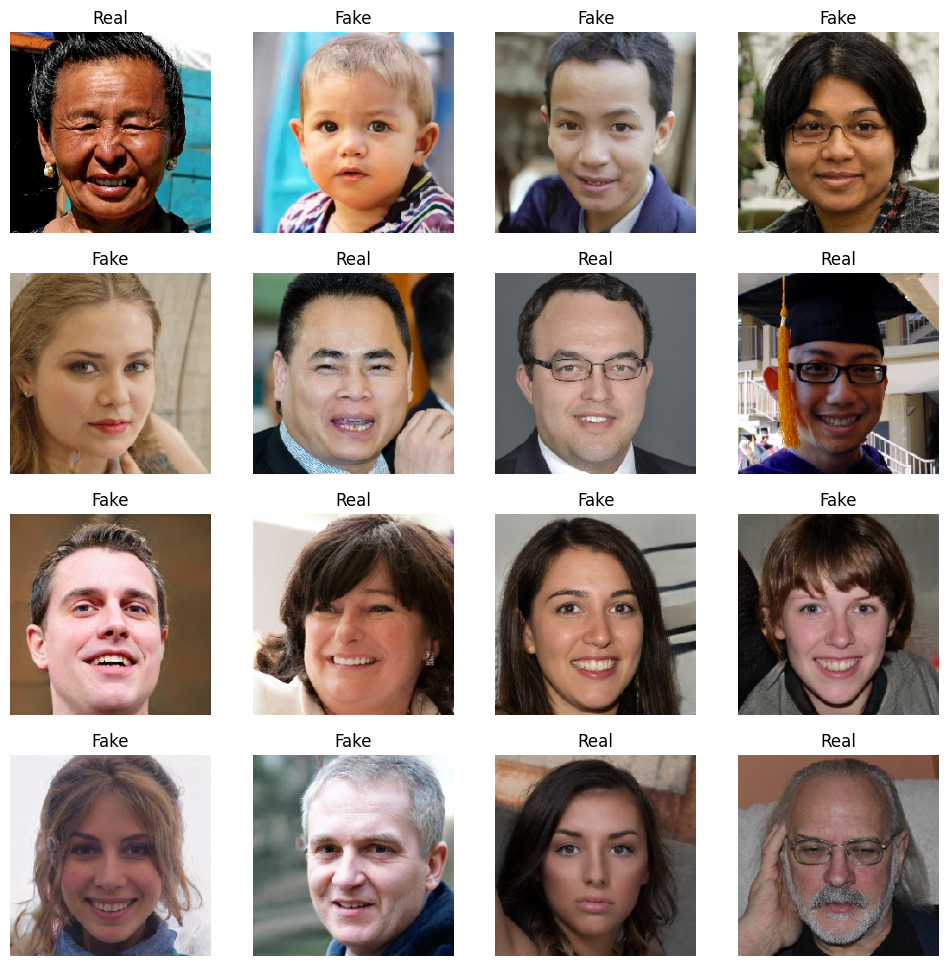

In [14]:
img,lbl = next(train_ds)
plot_images(img, lbl)

In [15]:
#Kiem tra nhan da dung chua
train_ds.class_indices

{'fake': 0, 'real': 1}

In [17]:
# Khởi tạo và biên dịch model
input_shape = (224, 224, 3)

In [18]:
def get_model(input_shape):

    input = tf.keras.Input(shape=input_shape)

    densenet = tf.keras.applications.DenseNet121( weights="imagenet", include_top=False, input_tensor = input)

    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) #binary classification

    model = tf.keras.Model(densenet.input, output)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

In [20]:
model_ft = get_model(input_shape)

In [21]:
checkpoint_filepath = "model_cp.weights.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

In [22]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=5,
                                                     restore_best_weights=True)

In [23]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

In [24]:
history_ft = model_ft.fit(train_ds,
                       epochs = 10,
                       validation_data = valid_ds,
                       callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr])

Epoch 1/10


I0000 00:00:1746341180.117224     123 service.cc:148] XLA service 0x7d030c001d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746341180.117837     123 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746341188.670324     123 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746341270.644584     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1479s 830ms/step - accuracy: 0.8879 - loss: 0.2645 - val_accuracy: 0.7606 - val_loss: 0.6306 - learning_rate: 0.0010
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 514s 328ms/step - accuracy: 0.9723 - loss: 0.0742 - val_accuracy: 0.9463 - val_loss: 0.1360 - learning_rate: 0.0010
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 513s 327ms/step - accuracy: 0.9790 - loss: 0.0551 - val_accuracy: 0.9496 - val_loss: 0.1302 - learning_rate: 0.0010
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 512s 326ms/step - accuracy: 0.9839 - loss: 0.0450 - val_accuracy: 0.9703 - val_loss: 0.0774 - learning_rate: 0.0010
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 513s 327ms/step - accuracy: 0.9854 - loss: 0.0379 - val_accuracy: 0.9650 - val_loss: 0.0925 - learning_rate: 0.0010
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 511s 326ms/step - accuracy: 0.9891 - loss: 0.0310 - val_accuracy: 0.9528 - val_loss: 0.1301 - learning_rate: 0.0010
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 515s 329ms/step - ac

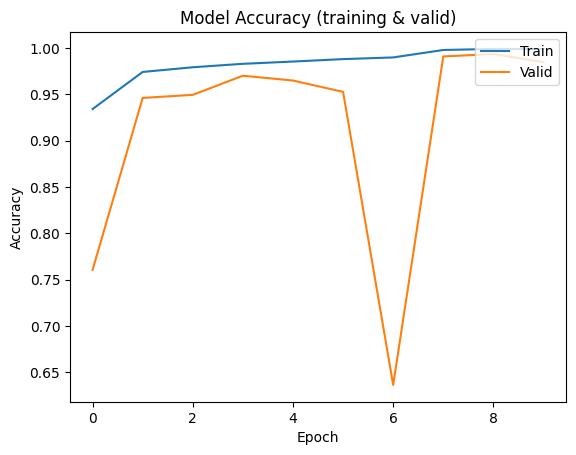

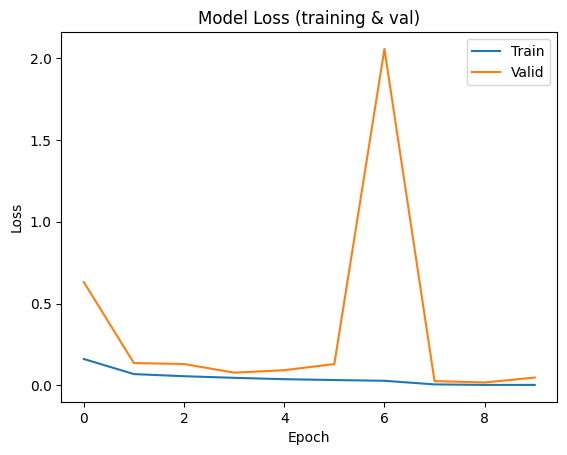

In [25]:
plt.plot(history_ft.history['accuracy'])
plt.plot(history_ft.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [26]:
# Evaluate the model on the test set
test_loss, test_acc = model_ft.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 202s 645ms/step - accuracy: 0.9963 - loss: 0.0106
Test Loss: 0.022525426000356674
Test Accuracy: 0.9925000071525574


In [35]:
model = get_model(input_shape)
model.load_weights('/kaggle/working/model_cp.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


Text(0.5, 1.0, 'This image is 100.00% Fake and 0.00% Real.')

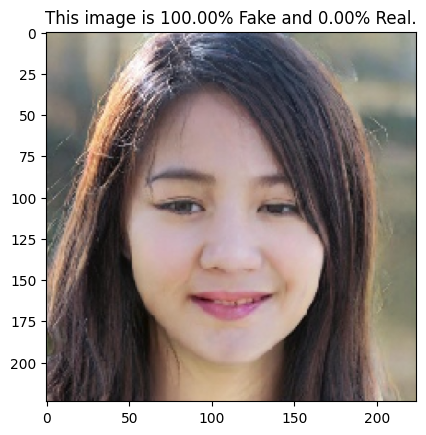

In [36]:
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00276TOPP4.jpg', target_size=(224, 224))
plt.imshow(test_image)

test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.

result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

In [37]:
model.save("model.h5")